In [2]:
!pip install numpy pandas seaborn matplotlib scikit-learn torch torchvision datasets transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.2-py3-none-manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached triton-3.2.0-cp31

In [8]:
!pip install jupyter ipywidgets

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached jupyter-1.1.1-py2.py3-none-any.whl (2.7 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
Using cached jupyter_console-6.6.3-py3-none-any.whl (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [jupyter]m2/5 [ipywidgets]


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn

from tqdm import tqdm

from datasets import load_dataset

from transformers import AutoTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding, DataCollatorForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback


In [3]:
device = torch.device("cuda")
print(device)

SEED_VALUE = 19
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

cuda


In [4]:
tokenizer = AutoTokenizer.from_pretrained("checkpoints/speech_roberta_mlm/checkpoint-600")


# ДАТАСЕТ

In [16]:
!head ./data/asian_boss.tsv

index	interviewer	respondent	active-reflexive
0	When you are speaking English as a Singaporean, are you aware that you have a certain accent?	Oh yes, hundred percent.	active
1		I uh I'm aware that I have a slight Singlish accent, I would say.	reflexive
2	Okay.	Like uh, even when I was in the States my friends told me that I had a little bit of an Asian accent because they didn't know which part I was from.	active
3	Okay.	Yeah.	active
4	When you are speaking English as a Singaporean, are you aware that you have a certain accent?	Um, I believe that when we speaks English, definitely to us, it sounds very natural. So we don't realize very often that we have a different accent.	active
5		But at the same time, I think it's a very common experience when we go overseas and we hear that Singlish accent and the all the additional "lahs" and everything that come out, and it's just very distinctive.	active
6		So, yes, very aware that we do sound very different, and perhaps this difference does ha

In [5]:
boss = pd.read_csv('data/asian_boss.tsv', sep='\t', usecols=["respondent", "active-reflexive"])
boss.rename(columns={"respondent": "text", "active-reflexive": "label"}, inplace=True)
boss

,text,label
0,"Oh yes, hundred percent.",active
1,I uh I'm aware that I have a slight Singlish a...,reflexive
2,"Like uh, even when I was in the States my frie...",active
3,Yeah.,active
4,"Um, I believe that when we speaks English, def...",active
...,...,...
132,that's a good question. ah it depends on if yo...,reflexive
133,"I don't know, like a million dollars?",reflexive
134,"uh yeah, I think it's very possible if you wor...",reflexive
135,"first piece of advice, try to come at higher l...",reflexive


In [6]:
alexa = pd.read_csv('data/Alexa_edited.tsv', sep='\t', usecols=["respondent", "active-reflexive"])
alexa.rename(columns={"respondent": "text", "active-reflexive": "label"}, inplace=True)
alexa.at[0, 'label'] = 'reflexive'
alexa

,text,label
0,"Okay. Great. Hi, everyone. Uh, my name is Farh...",reflexive
1,"Okay, great. Uh, my position is, uh, actually ...",reflexive
2,"The technical, yeah, all the technical issues,...",active
3,"Uh, actually I like aviation. So, and, uh, to ...",active
4,"This is not my native country, so that's why i...",reflexive
5,"Uh, sorry?",reflexive
6,"Uh, a little bit, yeah. A little. Actually, it...",reflexive
7,Uzbekistan is native country. I'm as a fish in...,reflexive
8,"Uh, the main motivation to improve my skills, ...",active
9,"Uh, probably, probably, uh, in Tashkent it was...",active


In [7]:
maula = pd.read_csv('data/Maula_edited.tsv', sep='\t', usecols=["respondent", "active-reflexive"], skiprows=[1])
maula.rename(columns={"respondent": "text", "active-reflexive": "label"}, inplace=True)
maula

,text,label
0,Okay.,reflexive
1,Okay.,reflexive
2,Okay. So my previous position is the call cent...,active
3,"And then I would call people and, uh, either t...",active
4,"I mean, it's the biggest like phone and TV and...",active
...,...,...
73,"For example, like, you know, you sometimes mee...",reflexive
74,"Like for example, you know, yeah, you shouldn'...",reflexive
75,"So I think it's kind of, I don't know, mix of ...",reflexive
76,"But yeah, culture I guess. I mean it's like c...",reflexive


In [8]:
data = pd.concat([boss, alexa, maula])
data.reset_index(inplace=True, drop=True)
data

,text,label
0,"Oh yes, hundred percent.",active
1,I uh I'm aware that I have a slight Singlish a...,reflexive
2,"Like uh, even when I was in the States my frie...",active
3,Yeah.,active
4,"Um, I believe that when we speaks English, def...",active
...,...,...
264,"For example, like, you know, you sometimes mee...",reflexive
265,"Like for example, you know, yeah, you shouldn'...",reflexive
266,"So I think it's kind of, I don't know, mix of ...",reflexive
267,"But yeah, culture I guess. I mean it's like c...",reflexive


In [9]:
marfenko = pd.read_csv('data/Marfenko_edited.tsv', sep='\t', usecols=["respondent", "active-reflexive"])
marfenko.rename(columns={"respondent": "text", "active-reflexive": "label"}, inplace=True)
marfenko

,text,label
0,The Moscow Exchange Group of Companies is esse...,reflexive
1,"And also various instruments for retail, both ...",active
2,I am the head of the department for creating a...,active
3,The company has a system in place that there i...,active
4,"And, accordingly, the second piece is a back-o...",reflexive
5,"Well, that is, my department is responsible fo...",active
6,"Also, as an accepted part, we have such an ent...",active
7,"Well, it certainly depends on the candidate's ...",reflexive
8,"For example, candidates with such experience, ...",active
9,"Accordingly, expectations from him, it is clea...",reflexive


In [10]:
data = pd.concat([data, marfenko])
data.reset_index(inplace=True, drop=True)
data

,text,label
0,"Oh yes, hundred percent.",active
1,I uh I'm aware that I have a slight Singlish a...,reflexive
2,"Like uh, even when I was in the States my frie...",active
3,Yeah.,active
4,"Um, I believe that when we speaks English, def...",active
...,...,...
297,"That is, as it were, of course, in general ter...",active
298,"Yes, it can vary greatly from day to day. But ...",reflexive
299,"It is difficult, of course, to say, considerin...",active
300,"At some point, for example, in the summer, we ...",active


In [11]:
data['text'] = data['text'].str.lower()
data

,text,label
0,"oh yes, hundred percent.",active
1,i uh i'm aware that i have a slight singlish a...,reflexive
2,"like uh, even when i was in the states my frie...",active
3,yeah.,active
4,"um, i believe that when we speaks english, def...",active
...,...,...
297,"that is, as it were, of course, in general ter...",active
298,"yes, it can vary greatly from day to day. but ...",reflexive
299,"it is difficult, of course, to say, considerin...",active
300,"at some point, for example, in the summer, we ...",active


In [12]:
data.replace('active', 1, inplace=True)
data.replace('reflexive', 0, inplace=True)
data

/tmp/ipykernel_1505/1644994870.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('reflexive', 0, inplace=True)


,text,label
0,"oh yes, hundred percent.",1
1,i uh i'm aware that i have a slight singlish a...,0
2,"like uh, even when i was in the states my frie...",1
3,yeah.,1
4,"um, i believe that when we speaks english, def...",1
...,...,...
297,"that is, as it were, of course, in general ter...",1
298,"yes, it can vary greatly from day to day. but ...",0
299,"it is difficult, of course, to say, considerin...",1
300,"at some point, for example, in the summer, we ...",1


In [13]:
from datasets import Dataset, DatasetDict

In [14]:
dataset = Dataset.from_pandas(data)
dataset[0]

{'text': 'oh yes, hundred percent.', 'label': 1}

In [15]:
train_testvalid = dataset.train_test_split(test_size=0.2)
train_testvalid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
train_test_valid_dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 241
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 31
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 30
    })
})

In [16]:
def tokenize_text(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        #padding="max_length",
    )

train_tokenised = train_test_valid_dataset['train'].map(tokenize_text, batched=True, num_proc=8)
val_tokenised = train_test_valid_dataset['valid'].map(tokenize_text, batched=True, num_proc=8)
test_tokenised = train_test_valid_dataset['test'].map(tokenize_text, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/241 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/30 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/31 [00:00<?, ? examples/s]

In [17]:
train_tokenised[10]

{'text': "i mean, it's the biggest like phone and tv and like network operator in my country. so, um, they have call centers. they do a lot of business with the government and like when i was working there, there was different this like, um, section. so i was, uh, on the outgoing calls. ",
 'label': 1,
 'input_ids': [0,
  118,
  1266,
  6,
  24,
  18,
  5,
  934,
  101,
  1028,
  8,
  30016,
  8,
  101,
  1546,
  5364,
  11,
  127,
  247,
  4,
  98,
  6,
  7252,
  6,
  51,
  33,
  486,
  5228,
  4,
  51,
  109,
  10,
  319,
  9,
  265,
  19,
  5,
  168,
  8,
  101,
  77,
  939,
  21,
  447,
  89,
  6,
  89,
  21,
  430,
  42,
  101,
  6,
  7252,
  6,
  2810,
  4,
  98,
  939,
  21,
  6,
  37463,
  6,
  15,
  5,
  14234,
  1519,
  4,
  1437,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [18]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# TRAINING

In [19]:
id2label = {0: "reflexive", 1: "active"}
label2id = {"reflexive": 0, "active": 1}

In [19]:
roberta_classifier = RobertaForSequenceClassification.from_pretrained("checkpoints/speech_roberta_mlm/checkpoint-600", num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at checkpoints/speech_roberta_mlm/checkpoint-600 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
roberta_classifier.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [53]:
!pip install 'accelerate>=0.26.0'

  Using cached accelerate-1.7.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.7.0-py3-none-any.whl (362 kB)


In [57]:
!pip install transformers[torch]

  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.2-py3

In [22]:
training_args = TrainingArguments(
    output_dir="checkpoints/speech_roberta_classification",
    overwrite_output_dir=True,

    num_train_epochs=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,

    eval_strategy="steps",
    #evaluation_strategy="epoch",
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    save_total_limit=3,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    fp16=True,
    logging_dir="logs/finetune",

    optim="adamw_torch_fused",
    dataloader_pin_memory=True,
    dataloader_num_workers=8,
    gradient_checkpointing=True,

)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    fpr, tpr, thresholds = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [24]:
trainer = Trainer(
    model=roberta_classifier,
    args=training_args,
    train_dataset=train_tokenised,
    eval_dataset=val_tokenised,
    data_collator=data_collator,
    callbacks=[early_stopping],
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
100,0.182600,0.994995,0.766667,0.763333,0.766667,0.764103,0.739234
200,0.000500,4.833129,0.700000,0.693056,0.700000,0.673324,0.629187


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=200, training_loss=0.13202063389122487, metrics={'train_runtime': 3190.5802, 'train_samples_per_second': 15.107, 'train_steps_per_second': 0.063, 'total_flos': 3891738828149700.0, 'train_loss': 0.13202063389122487, 'epoch': 200.0})

In [25]:
trainer.state.best_model_checkpoint

'checkpoints/speech_roberta_classification/checkpoint-100'

In [1]:
training_args = TrainingArguments(
   training_args = TrainingArguments(
    output_dir="checkpoints/speech_roberta_classification",
    overwrite_output_dir=True,

    num_train_epochs=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,

    eval_strategy="steps",
    #evaluation_strategy="epoch",
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    save_total_limit=3,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    fp16=True,
    logging_dir="logs/finetune",

    optim="adamw_torch_fused",
    dataloader_pin_memory=True,
    dataloader_num_workers=8,
    gradient_checkpointing=True,

)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3
)


trainer = Trainer(
    model=roberta_classifier,
    args=training_args,
    train_dataset=train_tokenised,
    eval_dataset=val_tokenised,
    data_collator=data_collator,
    callbacks=[early_stopping],
    compute_metrics=compute_metrics,
)

trainer.train(resume_from_checkpoint=True)
#trainer.train()

NameError: name 'TrainingArguments' is not defined

In [26]:
roberta_classifier_og = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
training_args2 = TrainingArguments(
    output_dir="checkpoints/speech_roberta_classification_og",
    overwrite_output_dir=True,

    num_train_epochs=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,

    eval_strategy="steps",
    #evaluation_strategy="epoch",
    eval_steps=50,
    logging_steps=50,
    save_steps=50,
    save_total_limit=3,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    fp16=True,
    logging_dir="logs/finetune",

    optim="adamw_torch_fused",
    dataloader_pin_memory=True,
    dataloader_num_workers=8,
    gradient_checkpointing=True,

)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [30]:
trainer = Trainer(
    model=roberta_classifier_og,
    args=training_args2,
    train_dataset=train_tokenised,
    eval_dataset=val_tokenised,
    data_collator=data_collator,
    callbacks=[early_stopping],
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
50,0.341900,0.639785,0.666667,0.781609,0.666667,0.562500,0.545455
100,0.172400,1.141300,0.733333,0.730021,0.733333,0.716402,0.674641
150,0.000700,3.742014,0.700000,0.693056,0.700000,0.673324,0.629187
200,0.000000,4.910664,0.666667,0.650104,0.666667,0.645503,0.602871


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=200, training_loss=0.12874172754350638, metrics={'train_runtime': 3189.1535, 'train_samples_per_second': 15.114, 'train_steps_per_second': 0.063, 'total_flos': 3891738828149700.0, 'train_loss': 0.12874172754350638, 'epoch': 200.0})

In [32]:
data['label'].value_counts()

label
0    171
1    131
Name: count, dtype: int64

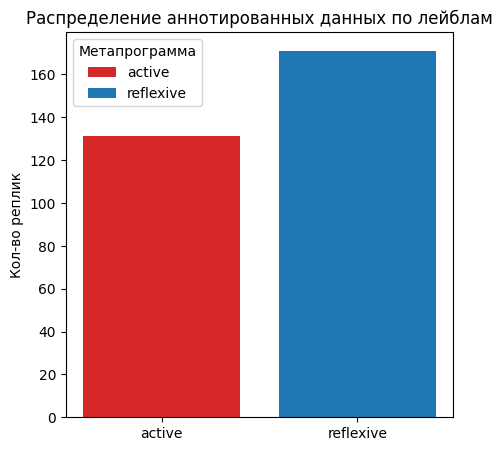

In [38]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

fruits = ['active', 'reflexive']
counts = [131, 171]
bar_labels = ['active', 'reflexive']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Кол-во реплик')
ax.set_title('Распределение аннотированных данных по лейблам')
ax.legend(title='Метапрограмма')

plt.show()